In [292]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.feature_selection import f_classif
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import sklearn.naive_bayes as nb

In [293]:
dataset = pd.read_csv('dataset/diabetes.csv')
dataset.shape

(768, 9)

## Data Preprocessing

In [294]:
dataset.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [295]:
cols =['Glucose','BloodPressure','SkinThickness','Insulin','BMI','Age', "DiabetesPedigreeFunction"]
d = dataset.copy()
d[cols] = d[cols].replace({'0':np.nan, 0:np.nan})
d.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

Drop Insulin and Skin Thickness columns due to lots of missing values. We also dropped the Pregnancies column to generalize the model for males and females and replaced missing values in the remaining columns with their medians.

In [296]:
dataset.drop("Insulin",axis=1,inplace=True)
dataset.drop("SkinThickness",axis=1,inplace=True)
dataset.drop("Pregnancies",axis=1,inplace=True)
dataset.loc[dataset.Glucose == 0,'Glucose'] = dataset["Glucose"].median()
dataset.loc[dataset.BloodPressure == 0,'BloodPressure'] = dataset["BloodPressure"].median()
dataset.loc[dataset.BMI == 0,'BMI'] = dataset["BMI"].median()

<AxesSubplot:ylabel='DiabetesPedigreeFunction'>

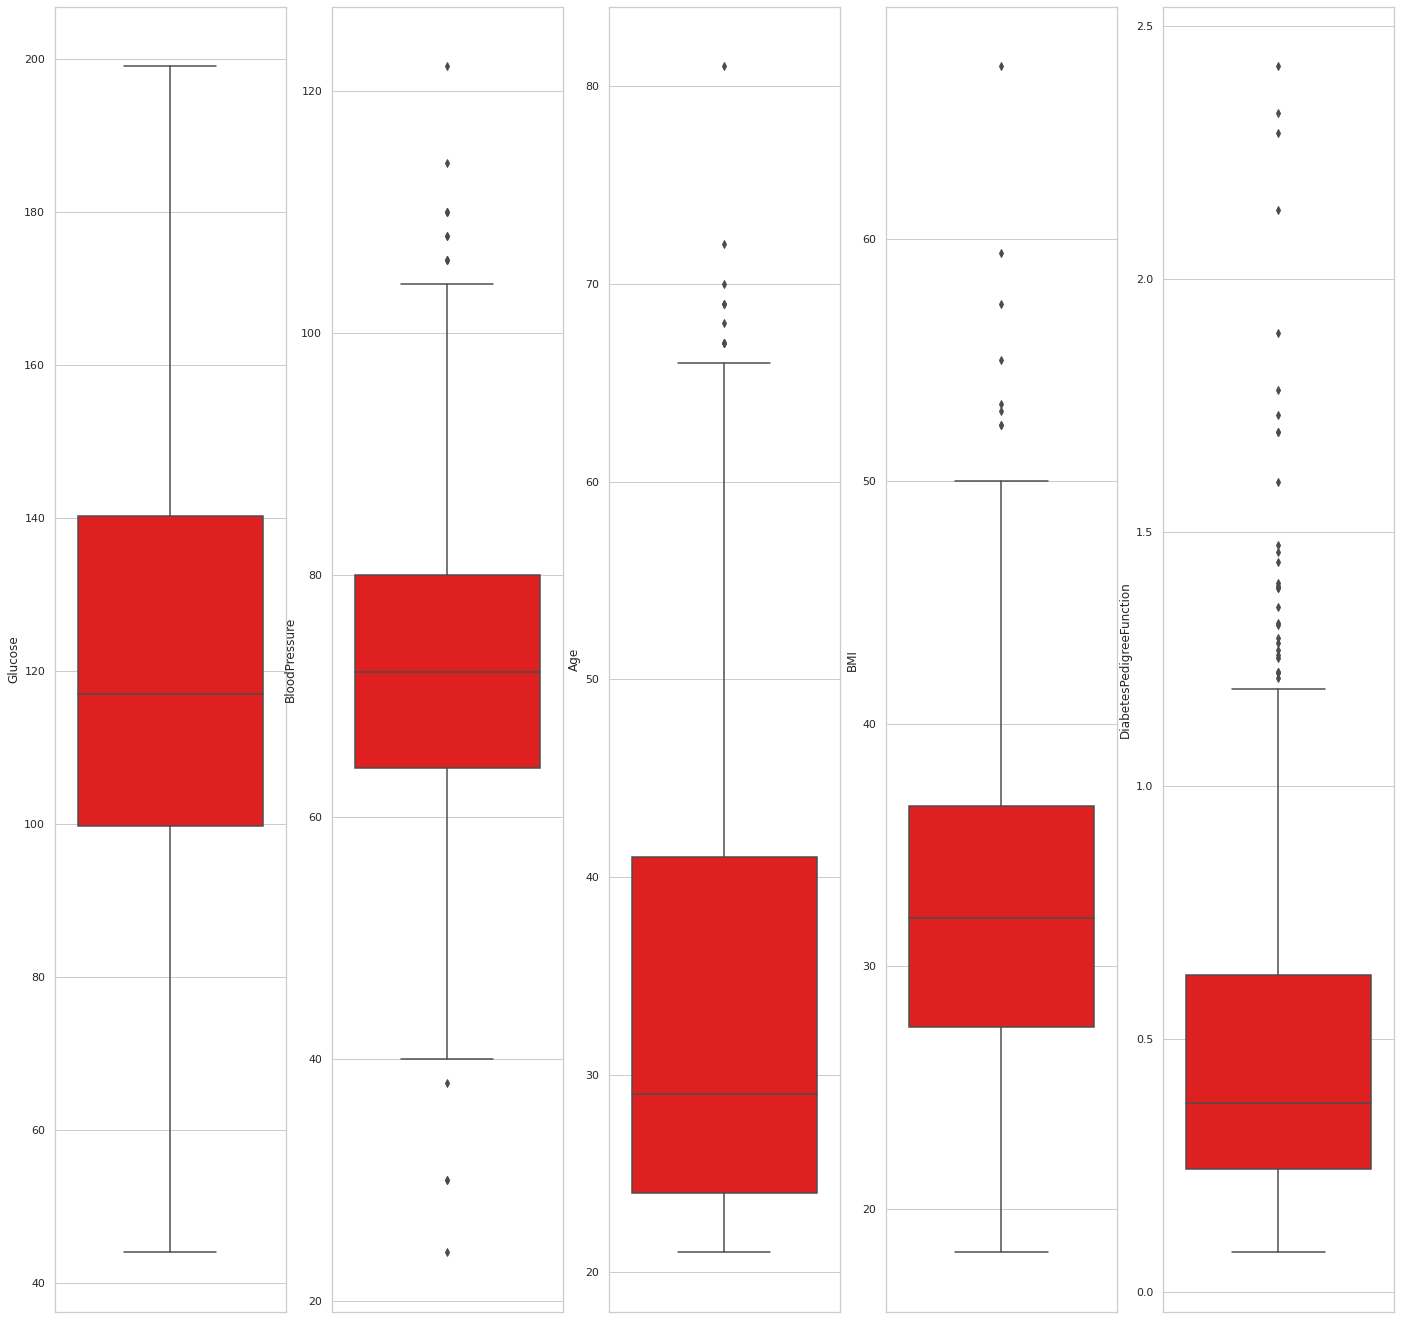

In [297]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(24,24), nrows=1, ncols=5)
sns.boxplot(data=dataset, y="Glucose", ax=ax[0], color='red')
sns.boxplot(data=dataset, y="BloodPressure", ax=ax[1], color='red')
sns.boxplot(data=dataset, y="Age", ax=ax[2], color='red')
sns.boxplot(data=dataset, y="BMI", ax=ax[3], color='red')
sns.boxplot(data=dataset, y="DiabetesPedigreeFunction", ax=ax[4], color='red')

We used analysis of variance (ANOVA) to test the dispersion of each feature with respect to the outcome. All values had significant p-values.

In [298]:
f,p = f_classif(dataset.iloc[:,:-1],dataset.iloc[:,-1])
print(f)
print(p)

[245.66785542  21.63157981  82.75294974  23.8713002   46.14061124]
[3.12871904e-48 3.89083549e-06 7.87914762e-19 1.25460701e-06
 2.20997546e-11]


Plot the distribution of all features

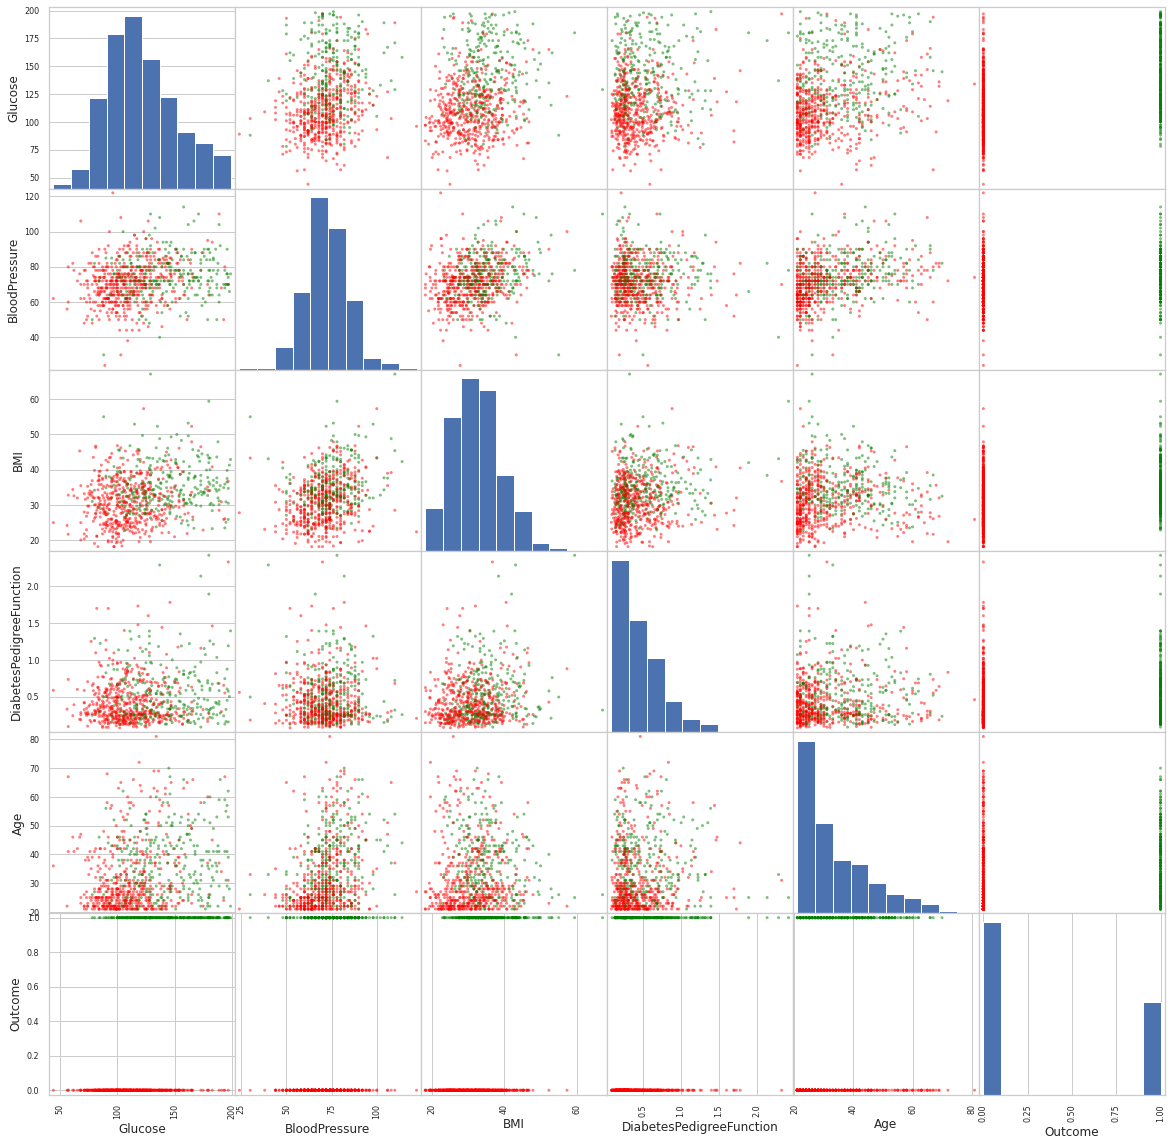

In [299]:
pd.plotting.scatter_matrix(dataset.iloc[:,:], c=dataset.iloc[:,-1].replace({0:"red",1:"green"}), alpha=0.5, figsize=(20,20))
plt.show()

Plot the correlation matrix. There were no highly correlated features.

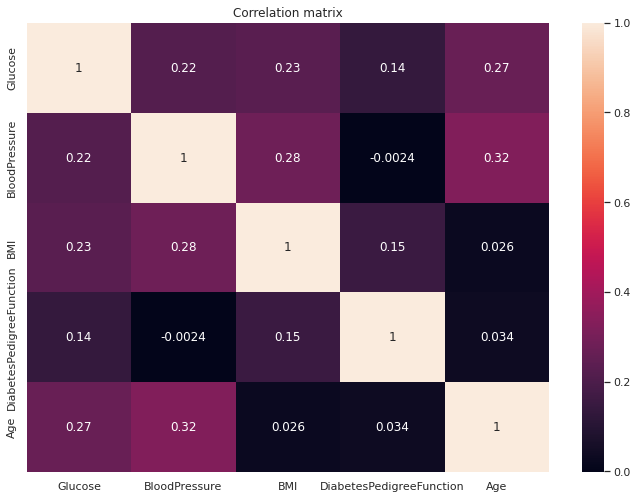

In [300]:
hm = sns.heatmap(dataset.iloc[:,:-1].corr(), annot = True)
hm.set(title = "Correlation matrix")
plt.show()

Scale the data then train using different models.

In [301]:
X_train, X_test, y_train, y_test = train_test_split(dataset.iloc[:,:-1].values,dataset.iloc[:,-1].values,test_size=0.2,random_state=0)

log = make_pipeline(StandardScaler(),LogisticRegression(random_state = 0))
log_score = cross_val_score(log, X_train, y_train, cv=5)

DT = make_pipeline(StandardScaler(), DecisionTreeClassifier(criterion = 'entropy', random_state = 0))
DT_score = cross_val_score(DT, X_train, y_train, cv=5)

SV = make_pipeline(StandardScaler(),SVC(kernel = 'linear', random_state = 0))
SV_score = cross_val_score(SV, X_train, y_train, cv=5)

NB = make_pipeline(StandardScaler(),nb.GaussianNB())
NB_score = cross_val_score(SV, X_train, y_train, cv=5)

print("Logistic Regression cross validation mean",log_score.mean())
print("Decision Tree cross validation mean: ",DT_score.mean())
print("Support Vector cross validation mean: ",SV_score.mean())
print("Naive Bayes cross validation mean",NB_score.mean())

y_log = log.fit(X_train,y_train).predict(X_test)
y_DT = DT.fit(X_train,y_train).predict(X_test)
y_SV = SV.fit(X_train,y_train).predict(X_test)
y_NB = NB.fit(X_train,y_train).predict(X_test)

Logistic Regression cross validation mean 0.7703585232573638
Decision Tree cross validation mean:  0.6824203651872585
Support Vector cross validation mean:  0.7638544582167134
Naive Bayes cross validation mean 0.7638544582167134


In [302]:
def discretize(dataset):
    datasetcopy=dataset.copy()
    datasetcopy.loc[datasetcopy.Age <= 30,'Age'] = 1
    datasetcopy.loc[(datasetcopy.Age >30) & (datasetcopy.Age <= 40),'Age'] = 2
    datasetcopy.loc[(datasetcopy.Age >40) & (datasetcopy.Age <= 50),'Age'] = 3
    datasetcopy.loc[(datasetcopy.Age >50) & (datasetcopy.Age <= 60),'Age'] = 4
    datasetcopy.loc[datasetcopy.Age > 60,'Age'] = 5

    datasetcopy.loc[datasetcopy.Glucose <= 60,'Glucose'] = 1
    datasetcopy.loc[(datasetcopy.Glucose >60) & (datasetcopy.Glucose <= 80),'Glucose'] = 2
    datasetcopy.loc[(datasetcopy.Glucose >80) & (datasetcopy.Glucose <= 140),'Glucose'] = 3
    datasetcopy.loc[(datasetcopy.Glucose >140) & (datasetcopy.Glucose <= 180),'Glucose'] = 4
    datasetcopy.loc[datasetcopy.Glucose > 180,'Glucose'] = 5

    datasetcopy.loc[datasetcopy.BloodPressure <= 60,'BloodPressure'] = 1
    datasetcopy.loc[(datasetcopy.BloodPressure >60) & (datasetcopy.BloodPressure <= 75),'BloodPressure'] = 2
    datasetcopy.loc[(datasetcopy.BloodPressure >75) & (datasetcopy.BloodPressure <= 90),'BloodPressure'] = 3
    datasetcopy.loc[(datasetcopy.BloodPressure >90) & (datasetcopy.BloodPressure <= 100),'BloodPressure'] = 4
    datasetcopy.loc[datasetcopy.BloodPressure > 100,'BloodPressure'] = 5

    datasetcopy.loc[datasetcopy.BMI < 19,'BMI'] = 1
    datasetcopy.loc[(datasetcopy.BMI >= 19) & (datasetcopy.BMI <= 24),'BMI'] = 2
    datasetcopy.loc[(datasetcopy.BMI >24) & (datasetcopy.BMI <= 30),'BMI'] = 3
    datasetcopy.loc[(datasetcopy.BMI >30) & (datasetcopy.BMI <= 40),'BMI'] = 4
    datasetcopy.loc[datasetcopy.BMI > 40,'BMI'] = 5
    return datasetcopy

Discretize the dataset into 5 bins

In [303]:
discretized_dataset = discretize(dataset)

X_train_discrete, X_test_discrete, y_train_discrete, y_test_discrete = train_test_split(discretized_dataset.iloc[:,:-1].values,discretized_dataset.iloc[:,-1].values,test_size=0.2,random_state=0)

log = LogisticRegression(random_state = 0)
log_score = cross_val_score(log, X_train, y_train, cv=5)

DT = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
DT_score = cross_val_score(DT, X_train, y_train, cv=5)

SV = SVC(kernel = 'linear', random_state = 0)
SV_score = cross_val_score(SV, X_train, y_train, cv=5)

NB = nb.GaussianNB()
NB_score = cross_val_score(SV, X_train, y_train, cv=5)

print("Logistic Regression cross validation mean",log_score.mean())
print("Decision Tree cross validation mean: ",DT_score.mean())
print("Support Vector cross validation mean: ",SV_score.mean())
print("Naive Bayes cross validation mean",NB_score.mean())

y_log_discrete = log.fit(X_train,y_train).predict(X_test)
y_DT_discrete = DT.fit(X_train,y_train).predict(X_test)
y_SV_discrete = SV.fit(X_train,y_train).predict(X_test)
y_NB_discrete= NB.fit(X_train,y_train).predict(X_test)

Logistic Regression cross validation mean 0.7671064907370384
Decision Tree cross validation mean:  0.6807943489270958
Support Vector cross validation mean:  0.7622151139544182
Naive Bayes cross validation mean 0.7622151139544182


In [304]:
pd.DataFrame({
    "Discrete": [accuracy_score(y_test_discrete,y_SV_discrete),accuracy_score(y_test_discrete,y_DT_discrete),accuracy_score(y_test_discrete,y_log_discrete),accuracy_score(y_test_discrete,y_NB_discrete)],
    "Continuous": [accuracy_score(y_test,y_DT),accuracy_score(y_test,y_DT),accuracy_score(y_test,y_log),accuracy_score(y_test,y_NB)]
}, index= ["Support Vector Classifier","Decision Tree","Logistic Regression","Naive Bayes"])

,Discrete,Continuous
Support Vector Classifier,0.798701,0.798701
Decision Tree,0.805195,0.798701
Logistic Regression,0.805195,0.805195
Naive Bayes,0.785714,0.785714
